# Solid - Liquid Equilibria (Menthol + Octanoic acid)

In [1]:
import numpy as np
from epcsaftpy import component, pcsaft
import matplotlib.pyplot as plt
from scipy import optimize

**Parameters Menthol & Octanoic acid from:**<br />
M. Martins, E. Crespo, P. Pontes, L. Silva, M. Bülow, G. Maximo, E. Batista, C. Held, S. Pinho, and J. Coutinho. ACS Sustainable Chem. Eng. 6, 8836−8846 (2018). https://doi.org/10.1021/acssuschemeng.8b01203

In [2]:
OcAc = component('Octanoic acid (Caprylic acid)', ms = 7.0480, sigma = 3.1360, eps = 234.36,
                 kappaAB = 0.02000, eAB = 1889.20, sites = [0, 1, 1], Mw =  144.21)
Ment = component('Menthol', ms = 4.152, sigma = 3.903, eps = 262.40,
                 kappaAB = 0.0996, eAB = 1785.6 , sites = [0, 1, 1], Mw =  156.27 )
mix = OcAc + Ment  
mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = -0.0667)
saft = pcsaft(mix)

# Melting properties
Tm1, dHm1 = 288.20, 19.80e3 # K | J/mol 
Tm2, dHm2 = 315.68, 12.89e3 # K | J/mol 
Tmi = np.array([Tm1, Tm2])
dHmi = np.array([dHm1, dHm2])

## Objective functions for the SLE
Considering that the solid phases crystallize independently as pure solids and neglecting the effect of temperature on the heat capacities, the solubility of a solid in a liquid solvent can be described using the following expression: 
$$\ln(x_i \gamma_i^L) = \dfrac{\Delta_m H_i}{R} \left( \dfrac{1}{T_{m,i}} - \dfrac{1}{T} \right) + \dfrac{\Delta_m C_{p,i}}{R} \left( \dfrac{T_{m,i}}{T} - \ln \dfrac{T_{m,i}}{T} - 1 \right)$$

Usually, the last term has a negligible value when compared with the first and thus it was not taken into account.
$$OF(T) = \dfrac{\Delta_m H_i}{R} \left( \dfrac{1}{T_{m,i}} - \dfrac{1}{T} \right) - \ln(x_i \gamma_i^L) $$ 

In [3]:
R = 8.31446312572960                              # [J mol-1 K-1] Ideal gas constant

def fobj_sle(inc, x1, P, index_comp, saft):       # Solving the SLE for each molar composition
    T = inc[0]
    x = np.array([x1, 1 - x1])
    lngamma = saft.get_lngamma(x, T, P)

    fo = dHmi[index_comp]/R
    fo *= 1/Tmi[index_comp] - 1./T
    fo -= lngamma[index_comp]
    fo -= np.log(x[index_comp])
    
    return fo

def fobj_eut(inc, P, saft):                        # Solving the eutectic point.
    x1, T = inc
    x = np.array([x1, 1 - x1])
    lngamma = saft.get_lngamma(x, T, P)

    fo = dHmi/R
    fo *= 1/Tmi - 1./T
    fo -= lngamma
    fo -= np.log(x)

    return fo

### Finding the eutectic point

In [4]:
P   = 1.01325e5             # Pressure [Pa]
X0  = [0.55, 250.0]         # Initial Guess (x0, T0) 
out = optimize.root(fobj_eut, X0, args = (P, saft))
x1eut = out.x[0]
Teut = out.x[1]

print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("x1E      :", round(x1eut,5))
print("TE [K]   :", round(Teut,3))

RESULTS
_________________________________
message  : The solution converged.
success  : True
x1E      : 0.53032
TE [K]   : 259.221


### SLE calculation

In [5]:
n = 50
# Calculation from component 2 to eutectic point.
T0 = Tmi[1] 
x1A = np.linspace(0., x1eut, n)
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1A[i], P, 1, saft))
    T0 = out.x[0]
    TA[i] = T0
    xA = np.array([x1A[i], 1 - x1A[i]])
    lngamma = saft.get_lngamma(xA, T0, P)
    gamm1A[i], gamm2A[i] = np.exp(lngamma)
    
# Calculation from eutectic point to component 2. 
x1B = np.linspace(x1eut, 1., n)
TB = np.zeros_like(x1A)
gamm1B = np.zeros_like(x1B)
gamm2B = np.zeros_like(x1B)
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1B[i], P, 0, saft))
    T0 = out.x[0]
    TB[i] = T0
    xB = np.array([x1B[i], 1 - x1B[i]])
    lngamma = saft.get_lngamma(xB, T0, P)
    gamm1B[i], gamm2B[i] = np.exp(lngamma)

c:\Users\Esteban\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


### SLE diagram
**Experimental information from:** <br />
M. Martins, E. Crespo, P. Pontes, L. Silva, M. Bülow, G. Maximo, E. Batista, C. Held, S. Pinho, and J. Coutinho. ACS Sustainable Chem. Eng. 6, 8836−8846 (2018). https://doi.org/10.1021/acssuschemeng.8b01203

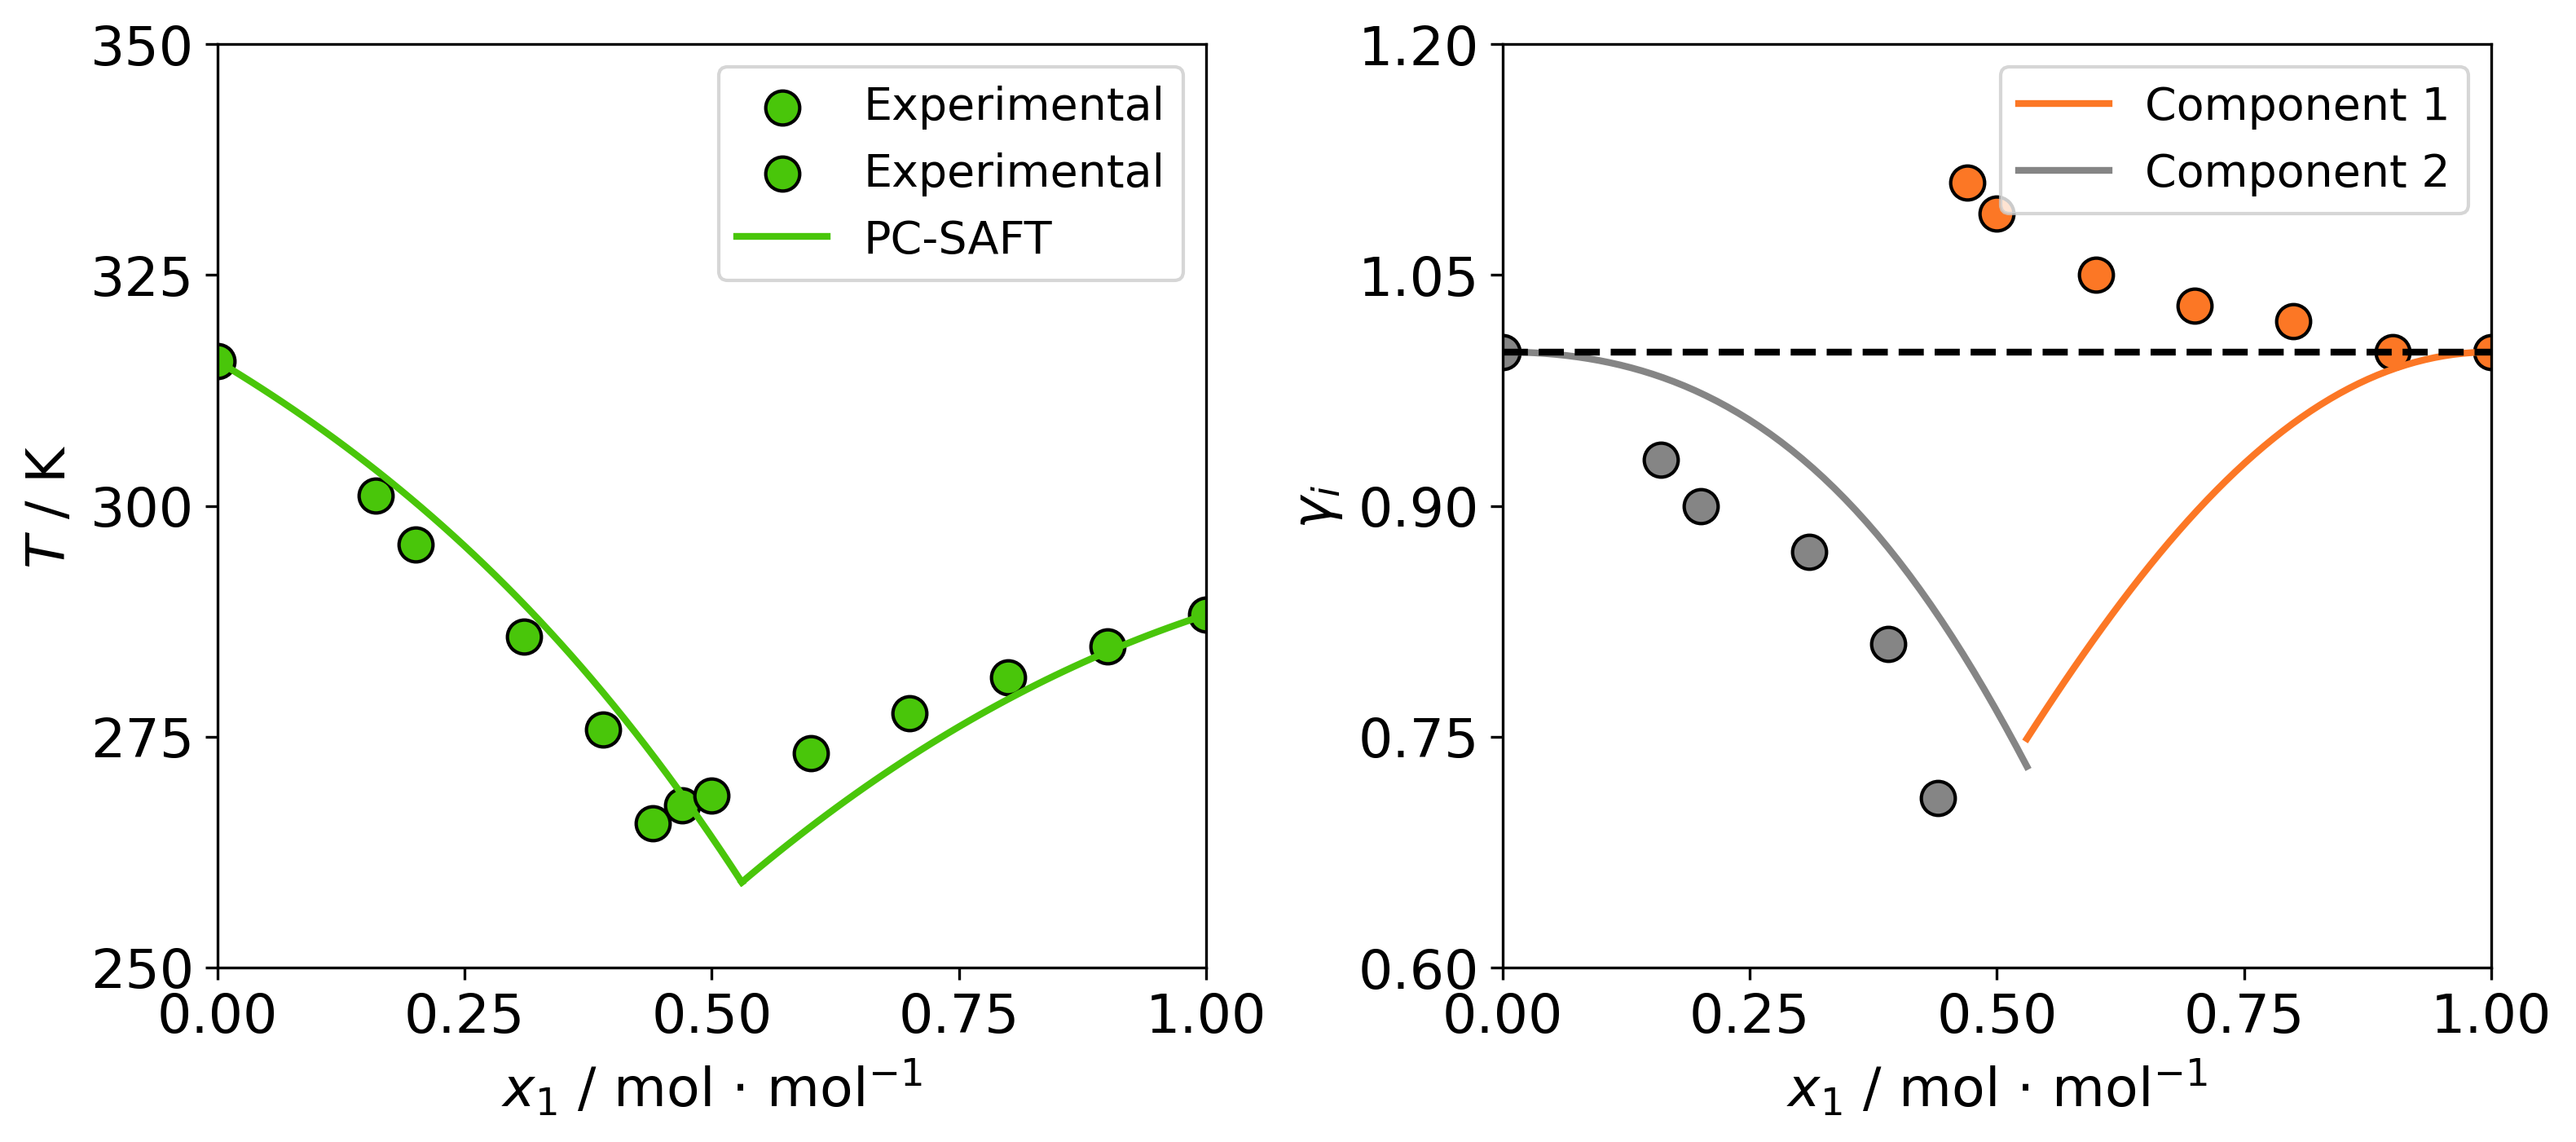

In [6]:
          
TAexp = np.array([315.68, 301.09, 295.81, 285.87, 275.8, 265.57])           
TBexp = np.array([267.57, 268.65, 273.22, 277.54, 281.42, 284.76, 288.2])           
x1Aexp = np.array([0, 0.16, 0.2, 0.31, 0.39, 0.44])
x1Bexp = np.array([0.47, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
gammA2exp = np.array([1, 0.93, 0.9, 0.87, 0.81, 0.71])
gammB1exp = np.array([1.11, 1.09, 1.05, 1.03, 1.02, 1, 1.])


font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorSLE = "#49C60A"

fig, axs = plt.subplots(1,2, figsize=(12, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax = axs[0]
ax.scatter(x1Aexp, TAexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(x1Bexp, TBexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.plot(x1A, TA, color = colorSLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(x1B, TB, color = colorSLE , 
        linewidth = 2.0)

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 250., 350.])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))


ax = axs[1]
color1 = "#FC7725"
color2 = "#858585"
ax.scatter(x1Aexp, gammA2exp, s = 100, c = color2, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.scatter(x1Bexp, gammB1exp, s = 100, c = color1, marker="o", 
            linewidth=1.0, edgecolor='k')
#ax.plot(x1A, gamm1A, color = color1 , 
#        linewidth = 2.0)
ax.plot(x1B, gamm1B, color = color1 , 
        linewidth = 2.0, label = "Component 1")
ax.plot(x1A, gamm2A, color = color2 , 
        linewidth = 2.0, label = "Component 2")
#ax.plot(x1B, gamm2B, color = color2 , 
#        linewidth = 2.0)

ax.plot([0,  1], [1, 1], color = "k", 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel(r'$\gamma_i$ ')
ax.set_xlabel(r'$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 0.6, 1.2])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()

## Fit binary parameter using the SLE

In [7]:
TAexp = np.array([301.09, 295.81, 285.87, 275.8, 265.57])           
TBexp = np.array([267.57, 268.65, 273.22, 277.54, 281.42, 284.76])           
x1Aexp = np.array([0.16, 0.2, 0.31, 0.39, 0.44])
x1Bexp = np.array([0.47, 0.5, 0.6, 0.7, 0.8, 0.9])

def fobj_keps(X):
    kepsij0 = X[0]
    mix = OcAc + Ment
    mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = kepsij0)
    saft = pcsaft(mix)
    
    nA = len(TAexp)
    TAcal = np.zeros_like(TAexp)
    for i in range(nA):
        out = optimize.root(fobj_sle, TAexp[i], args = (x1Aexp[i], P, 1, saft))
        if out.success:
            TAcal[i] = out.x[0]
    errorA = (1 - TAcal/TAexp)
    
    nB = len(TBexp)
    TBcal = np.zeros_like(TBexp)
    for i in range(nB):
        out = optimize.root(fobj_sle, TBexp[i], args = (x1Bexp[i], P, 0, saft))
        if out.success:
            TBcal[i] = out.x[0]
    errorB = (1 - TBcal/TBexp)
    return np.append(errorA, errorB)

def aad(kepsij0):
    mix = OcAc + Ment
    mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = kepsij0)
    saft = pcsaft(mix)
    
    nA = len(TAexp)
    TAcal = np.zeros_like(TAexp)
    for i in range(nA):
        out = optimize.root(fobj_sle, TAexp[i], args = (x1Aexp[i], P, 1, saft))
        if out.success:
            TAcal[i] = out.x[0]
    aadA = np.abs(TAexp - TAcal)
    
    nB = len(TBexp)
    TBcal = np.zeros_like(TBexp)
    for i in range(nB):
        out = optimize.root(fobj_sle, TBexp[i], args = (x1Bexp[i], P, 0, saft))
        if out.success:
            TBcal[i] = out.x[0]
    aadB = np.abs(TBexp - TBcal)
    return np.sum(np.append(aadA, aadB))/(nA + nB)
    

In [8]:
method = 'lm'
out = optimize.least_squares(fobj_keps, 0., method = method)
out 

 active_mask: array([0])
        cost: 0.0029193524945713943
         fun: array([-0.01075927, -0.01794653, -0.01932327, -0.02757878, -0.04672323,
        0.0306977 ,  0.02622182,  0.01733386,  0.01087569,  0.00575644,
        0.00141916])
        grad: array([3.74748583e-09])
         jac: array([[-0.03213761],
       [-0.05312074],
       [-0.14650906],
       [-0.25805829],
       [-0.35539658],
       [-0.40663121],
       [-0.36341933],
       [-0.2339008 ],
       [-0.1315416 ],
       [-0.05815496],
       [-0.01438743]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 9
        njev: None
  optimality: 3.747485829465325e-09
      status: 2
     success: True
           x: array([-0.01831673])

In [9]:
AAD = aad(-0.01831802)
print(f"AAD \ K keps fit = {round(AAD,2)}")
AAD = aad(0.)
print(f"AAD \ k keps 0 = {round(AAD,2)}")

AAD \ K keps fit = 5.37
AAD \ k keps 0 = 5.22
